In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Embedding,Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import re
from sklearn.model_selection import KFold

# Reading Intent Dataset

In [2]:
data=pd.read_csv('intent12-corrected.csv',delimiter = ';',names=['Text','Intent'],encoding="utf-8")
data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(10561, 2)


,Text,Intent
0,Kiyyoo dirama oso eguti jirun na darbe tari a...,Question
1,Meeti ree kuta 28ffaa,Question
2,Kutaa digdami sadetaffa isiin egee dadhabee.,Negative
3,Kutaa digdami sadetaffaa fiidagaa maali nuuraa...,Negative
4,Nuuf jabbadhakaa warii Akka kotti kiyyoo jaala...,Positive


<AxesSubplot:xlabel='Intent', ylabel='count'>

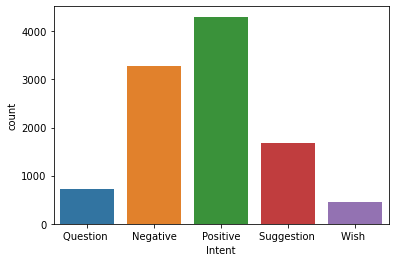

In [3]:
sns.countplot(x='Intent', data=data)

In [4]:
data["Intent"].value_counts()
#print(len('Gosa_miira'))
#print(len('jechoota'))

Positive       4301
Negative       3271
Suggestion     1686
Question        718
Wish            454
Name: Intent, dtype: int64

# Data Preprocessing

In [5]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sen.lower()
    sentence = re.sub(r'wo*w','wow', sentence)
    sentence = re.sub(r'uu*f','uff', sentence)
    return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(Text):
    return TAG_RE.sub('', Text)

In [6]:
def remove_stopwords(review_words):
    with open('stopwords.txt')as stopfile:
        stopwords=stopfile.read()
        list=stopwords.split()
        print(list)
        with open("intent1.csv") as workfile:
            read_data=workfile.read()
            data=read_data.split()
            print(data)
            for word1 in list:
                for word2 in data:
                    if word1==word2:
                        return data.remove(list)
                        print(remove_stopwords)

In [7]:
data['Text'].apply(lambda x: x.lower())

0        kiyyoo dirama oso  eguti jirun na darbe tari a...
1                                    meeti ree kuta 28ffaa
2             kutaa digdami sadetaffa isiin egee dadhabee.
3        kutaa digdami sadetaffaa fiidagaa maali nuuraa...
4        nuuf jabbadhakaa warii akka kotti kiyyoo jaala...
                               ...                        
10556    isheenis namoota dogoggoraa waliin lafa dogogg...
10557    vidiyichis battalumatti qoodamuun marsariitiiw...
10558    gochiwwan qaamaa warraabbicha irratti ture bah...
10559              jechi gurbbichaa altokkicha dhagahame. 
10560                           viidiyoo waraabaa jirtaa? 
Name: Text, Length: 10561, dtype: object

# Feature Extraction

In [8]:
tokenizer=Tokenizer(num_words=4000,split=" ")
tokenizer.fit_on_texts(data['Text'].values)
x=tokenizer.texts_to_sequences(data['Text'].values)
x=pad_sequences(x)
x[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  198, 3008, 3009,
          37,  194,  146,  325],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  432, 3297],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         159, 3298,  319,  413],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  159,
        3298,  154, 3094,   46],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   75, 3299,
           4, 3095,  198, 3300]])

In [9]:
y=pd.get_dummies(data['Intent']).values
[print(data['Intent'][i],y[i]) for i in range(0,5)]

Question  [0 0 1 0 0]
Question  [0 0 1 0 0]
Negative [1 0 0 0 0]
Negative [1 0 0 0 0]
Positive [0 1 0 0 0]


[None, None, None, None, None]

In [10]:
num_folds = 5
acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=num_folds, shuffle=True)

In [11]:
fold_no = 1
for train, test in kfold.split(x, y):
    model = Sequential()
    model.add(Embedding(4000, 64, input_length=x.shape[1]))
    model.add(Dropout(0.6))
    model.add(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.2))
    #model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.3))
    model.add(Dense(5, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(x[train], y[train], epochs=32, batch_size=64,validation_data=(x[test], y[test]), verbose=2)
    # Generate generalization metrics
    scores = model.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/32
132/132 - 35s - loss: 1.3216 - accuracy: 0.4205 - val_loss: 1.1738 - val_accuracy: 0.5121 - 35s/epoch - 261ms/step
Epoch 2/32
132/132 - 13s - loss: 0.8848 - accuracy: 0.6521 - val_loss: 0.7389 - val_accuracy: 0.7085 - 13s/epoch - 101ms/step
Epoch 3/32
132/132 - 13s - loss: 0.6067 - accuracy: 0.7644 - val_loss: 0.5968 - val_accuracy: 0.7605 - 13s/epoch - 100ms/step
Epoch 4/32
132/132 - 13s - loss: 0.4721 - accuracy: 0.8156 - val_loss: 0.5413 - val_accuracy: 0.7918 - 13s/epoch - 98ms/step
Epoch 5/32
132/132 - 13s - loss: 0.4085 - accuracy: 0.8389 - val_loss: 0.5384 - val_accuracy: 0.7984 - 13s/epoch - 100ms/step
Epoch 6/32
132/132 - 13s - loss: 0.3743 - accuracy: 0.8509 - val_loss: 0.4590 - val_accuracy: 0.8112 - 13s/epoch - 99ms/step
Epoch 7/32
132/132 - 13s - loss: 0.3427 - accuracy: 0.8620 - val_loss: 0.4314 - val_accuracy: 0.8315 - 13s/epoch - 99ms/step
Epoch 8/32
132/132 - 13s

Epoch 28/32
133/133 - 15s - loss: 0.1921 - accuracy: 0.9085 - val_loss: 0.4653 - val_accuracy: 0.8527 - 15s/epoch - 113ms/step
Epoch 29/32
133/133 - 15s - loss: 0.1915 - accuracy: 0.9117 - val_loss: 0.4513 - val_accuracy: 0.8509 - 15s/epoch - 111ms/step
Epoch 30/32
133/133 - 16s - loss: 0.1876 - accuracy: 0.9140 - val_loss: 0.4606 - val_accuracy: 0.8513 - 16s/epoch - 119ms/step
Epoch 31/32
133/133 - 15s - loss: 0.1849 - accuracy: 0.9166 - val_loss: 0.4730 - val_accuracy: 0.8546 - 15s/epoch - 116ms/step
Epoch 32/32
133/133 - 15s - loss: 0.1834 - accuracy: 0.9187 - val_loss: 0.4539 - val_accuracy: 0.8546 - 15s/epoch - 115ms/step
Score for fold 2: loss of 0.4538726806640625; accuracy of 85.46401262283325%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.45839089155197144 - Accuracy: 85.18694043159485%
-----------------------------------------------------------

Epoch 15/32
133/133 - 15s - loss: 0.2410 - accuracy: 0.8958 - val_loss: 0.4129 - val_accuracy: 0.8499 - 15s/epoch - 112ms/step
Epoch 16/32
133/133 - 15s - loss: 0.2356 - accuracy: 0.8957 - val_loss: 0.4053 - val_accuracy: 0.8513 - 15s/epoch - 116ms/step
Epoch 17/32
133/133 - 16s - loss: 0.2331 - accuracy: 0.8983 - val_loss: 0.4120 - val_accuracy: 0.8452 - 16s/epoch - 122ms/step
Epoch 18/32
133/133 - 15s - loss: 0.2277 - accuracy: 0.8989 - val_loss: 0.4144 - val_accuracy: 0.8456 - 15s/epoch - 115ms/step
Epoch 19/32
133/133 - 15s - loss: 0.2242 - accuracy: 0.9034 - val_loss: 0.4101 - val_accuracy: 0.8509 - 15s/epoch - 116ms/step
Epoch 20/32
133/133 - 16s - loss: 0.2107 - accuracy: 0.9063 - val_loss: 0.4348 - val_accuracy: 0.8485 - 16s/epoch - 121ms/step
Epoch 21/32
133/133 - 21s - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.4149 - val_accuracy: 0.8490 - 21s/epoch - 161ms/step
Epoch 22/32
133/133 - 22s - loss: 0.2064 - accuracy: 0.9046 - val_loss: 0.4211 - val_accuracy: 0.8532 - 22s/epo

In [12]:
scores = model.evaluate(x[test], y[test], verbose=1)

66/66 [==============================] - 3s 38ms/step - loss: 0.4983 - accuracy: 0.8428


In [31]:
scores

[0.4983291029930115, 0.8428030014038086]

In [32]:
predictions = model.predict(x[test])

66/66 [==============================] - 4s 58ms/step


In [33]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [34]:
cm=metrics.confusion_matrix((y[test]).argmax(axis=1), predictions.argmax(axis=1))

In [35]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [36]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [37]:
print(FP)
print(FN)
print(TP)
print(TN)

[ 93. 120.  29.  62.  28.]
[92. 99. 32. 81. 28.]
[580. 750. 118. 267.  65.]
[1347. 1143. 1933. 1702. 1991.]


In [38]:
accuracy=(TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2*precision*recall/(precision+recall)

In [39]:
print("recall  ", recall)
print("precision",precision)
print("f1_score",f1_score)

recall   [0.86309524 0.88339223 0.78666667 0.76724138 0.69892473]
precision [0.86181278 0.86206897 0.80272109 0.81155015 0.69892473]
f1_score [0.86245353 0.87260035 0.79461279 0.788774   0.69892473]


In [40]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [41]:
accuracy(cm)

0.8428030303030303

In [42]:
from sklearn.model_selection import KFold as kf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [43]:
from sklearn.model_selection import cross_validate
def cross_validation(history, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=history,
                               x_tarin=_X,
                               y_train=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [44]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

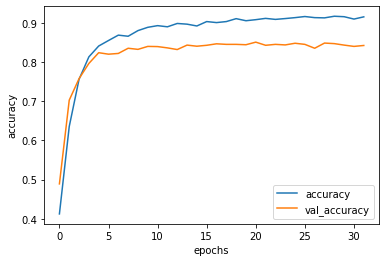

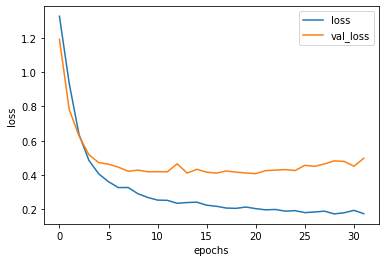

In [45]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [46]:
model.save("Intent_Classification_using_LSTM.h5")

In [47]:
new_intent = ['Kiyyoo dirama oso  eguti jirun na darbe tari ayaana moo sababa godhatu moyuu']
seq = tokenizer.texts_to_sequences(new_intent)
padded = pad_sequences(seq, maxlen=6000)
pred = model.predict(padded)
Intent = ['Positive', 'Negative', 'Suggestion', 'Question', 'Wish']
print(pred, Intent[np.argmax(pred)])

1/1 [==============================] - 4s 4s/step
[[4.9353554e-04 1.0295045e-05 9.9947828e-01 1.5720603e-05 2.3070850e-06]] Suggestion


In [48]:
[print (data['Text'][i], predictions[i], y[test[i]]) for i in range(0, 200)]

Kiyyoo dirama oso  eguti jirun na darbe tari ayaana moo sababa godhatu moyuu [4.6773512e-05 5.5271631e-01 4.6204414e-02 3.2389617e-01 7.7136315e-02] [0 1 0 0 0]
Meeti ree kuta 28ffaa [3.3783816e-02 1.7257239e-04 9.6589667e-01 1.1430731e-04 3.2723496e-05] [0 0 1 0 0]
Kutaa digdami sadetaffa isiin egee dadhabee. [2.4617006e-04 3.9727831e-05 9.9963427e-01 4.0669172e-05 3.9046161e-05] [0 0 1 0 0]
Kutaa digdami sadetaffaa fiidagaa maali nuuraa tuursiftaani bar ani 1faa haanga 27faa haarfoofan tuuree [9.1309536e-01 7.0152775e-04 8.3683766e-02 2.5065427e-03 1.2686354e-05] [1 0 0 0 0]
Nuuf jabbadhakaa warii Akka kotti kiyyoo jaalatan  [9.9705076e-01 2.8400256e-03 2.2357681e-05 8.6676002e-05 1.7396891e-07] [0 1 0 0 0]
Bayyee namatti tola itti fufa gariidha  [9.6439713e-01 4.8355426e-04 3.4712419e-02 3.9788231e-04 9.0149706e-06] [0 1 0 0 0]
Diraamichi torbetti yeroo lamaa nuuf dhiyaachuu qaba [9.9335879e-01 6.4165974e-03 9.0590846e-05 1.3377126e-04 2.6801160e-07] [1 0 0 0 0]
Ani dhugaa dubbachuu

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [49]:
cm=metrics.confusion_matrix((y[test]).argmax(axis=1), predictions.argmax(axis=1))

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [ ]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [ ]:
print(FP)
print(FN)
print(TP)
print(TN)

In [ ]:
accuracy=(TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2*precision*recall/(precision+recall)

In [ ]:
print("recall  ", recall)
print("precision",precision)
print("f1_score",f1_score)

In [ ]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [ ]:
accuracy(cm)

In [ ]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

In [ ]:
print("label precision recall")
for label in range(10):
    print(f"{label:4d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

In [ ]:
print("precision total:", precision_macro_average(cm))

print("recall total:", recall_macro_average(cm))

In [ ]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [ ]:
accuracy(cm)

In [ ]:
new_intent = ['Kiyyoo dirama oso  eguti jirun na darbe tari ayaana moo sababa godhatu moyuu']
seq = tokenizer.texts_to_sequences(new_intent)
padded = pad_sequences(seq, maxlen=6000)
pred = model.predict(padded)
Intent = ['Positive', 'Negative', 'Suggestion', 'Question', 'Wish']
print(pred, Intent[np.argmax(pred)])